<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%ED%8C%8C%EB%A8%B8ch9_6~8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**CHAPTER 9 추천 시스템**

###**06 아이템 기반 최접 이웃 협업 필터링 실습**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 데이터 가공 및 변환


In [ ]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings.csv')
print(movies.shape)    # 영화에 대한 메타 정보
print(ratings.shape)   # 사용자별 영화에 대한 평점

(9742, 3)
(100836, 4)


* 영화에 대한 메타 정보인 title과 genres를 가지고 있는 영화 정보

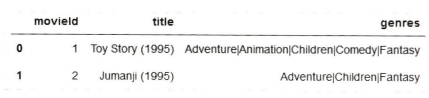

* 사용자별로 영화에 대한 평점을 매긴 데이터 세트

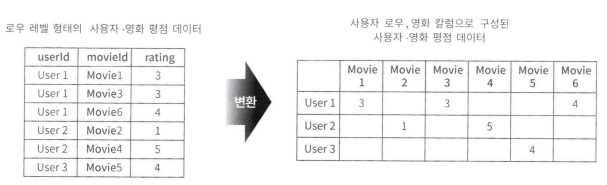

In [ ]:
ratings[['userId', 'movieId', 'rating']]
ratings_matirx = ratings.pivot_table('rating', index = 'userId', columns='movieId')
ratings_matirx.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


→ NaN이 많은 이유: 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환되면서 NaN이 할당되었기 때문

In [ ]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings,movies, on='movieId')

#columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**영화 간 유사도 산출**
* cosine_similarity() 활용

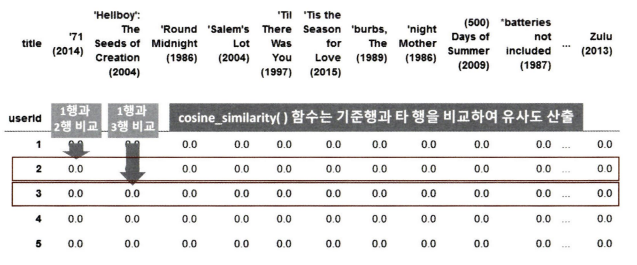

In [ ]:
# 전치행렬 생성
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬으 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                           columns=ratings_matrix.columns)

print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
# 영화 대부와 유사도 높은 상위 6개 추출
item_sim_df['Godfather, The (1972)'].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

→ 영화 대부를 제외하면 대부 2편의 유사도가 가장 높음

In [ ]:
# 인셉션과 유사도가 높은 상위 6개 영화 추출
item_sim_df['Inception (2010)'].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

**아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천**

개인화된 예측 평점 구하기

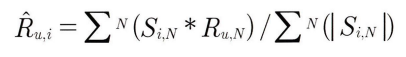

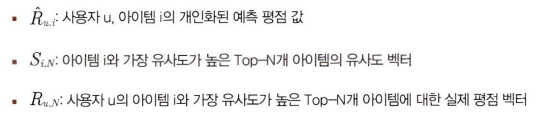

In [ ]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

In [ ]:
# 개인화된 예측 평점 구하기
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix=pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


In [ ]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 구함

def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred,actual)

print('아이템 기반 모든 최근접 이웃 MSE:' , get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE: 9.895354759094706


In [ ]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 맥주 개수만큼 루프
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개의 데이터 행렬의 인덱스 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점 계산 : 각 col 맥주별(1개), 2496 사용자들의 예측평점
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col,:][top_n_items].dot(
            ratings_arr[row, :][top_n_items].T)
            pred[row, col] /= np.sum(item_sim_arr[col,:][top_n_items])

    return pred

ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=10)
print('아이템 기반 최근접 TOP-N 이웃 MSE: ',
      get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index,
                                  columns=ratings_matrix.columns)


아이템 기반 최근접 TOP-N 이웃 MSE:  2.9213204909291965


→ MSE 기존의 9.89보다 많이 향상됨

In [ ]:
# 9번 아이디 사용자가 평점을 준 영화를 평점이 높은 순으로 나열
# 특정 유저 대상으로 추천
user_rating_id = ratings_matrix.loc[9, :]
# 유저가 먹었던 맥주들 출력
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

In [ ]:
from pandas.core.indexers import maybe_convert_indices

# 평점을 주지 않은 영화를 리스트 객체로 변환하는 함수
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환
    # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체
    user_rating = ratings_matrix.loc[userId, :]

    # user_rating이 0보다 크면 기존에 관란함 영화.대상 인덱스를 추출해 list 객체로 만듦
    already_seen = user_rating[user_rating>0].index.tolist()


    # 모든 영화명을 list 객체로 만듦
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 tried에 해당하는 영화는 movies_list에서 제외
    unseen_list = [movie for movie in movies_list if movie not in already_seen]

    return unseen_list


In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Spider-Man (2002),1.596006
"Lord of the Rings: The Return of the King, The (2003)",1.216477
"Last Samurai, The (2003)",1.100389
Indiana Jones and the Last Crusade (1989),0.981989
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.960896
Memento (2000),0.952082
Gladiator (2000),0.949712
Star Wars: Episode IV - A New Hope (1977),0.943552
Star Wars: Episode V - The Empire Strikes Back (1980),0.937478


###**07 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**

In [ ]:
def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [ ]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings.csv')
ratings[['userId', 'movieId', 'rating']]
ratings_matirx = ratings.pivot_table('rating', index = 'userId', columns='movieId')

In [ ]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings,movies, on='movieId')

#columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [ ]:
# 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [ ]:
# 영화 타이틀을 칼럼명으로 가지는 DF로 변경
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [ ]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함.
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임.
    user_rating = ratings_matrix.loc[userId,:]

    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()

    # 모든 영화명을 list 객체로 만듬.
    movies_list = ratings_matrix.columns.tolist()

    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함.
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]

    return unseen_list

In [ ]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함.
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [ ]:
# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690



###**08 파이썬 추천 시스템 패키지 - Surprise**

**Surprise 패키지 소개**

* Surprise: 파이썬 기반의 추천 시스템 구축을 위한 전용 패키지 중 하나
* Surprise는 파이썬 기반에서 사이킷런과 유사한 API와 프레임워크 제공
* Surprise 패키지는 API를 이용해 쉽게 추천 시스템을 구축할 수 있게 만들어짐
* 주요 장점
  * 다양한 추천 알고리즘, 예를 들어 사용자 또는 아이템 기반 최근접 이웃 협업 필터링, SVD, SVD++, NMF 기반의 잠재 요인 협업 필터링을 쉽게 적용해 추천 시스템을 구축할 수 있음
  * Surprise의 핵심 API는 사이킷런의 핵심 API와 유사한 API명으로 작성됨. 예를 들어 fit(), predict() API로 추천 데이터 학습과 예측, train_test_split()으로 추천 학습 데이터 세트와 예측 데이터 세트 분류, cross_validate(), GridSearchCV 클래스를 통해 추천 시스템을 위한 모델 셀렉션, 평가, 하이퍼 파라미터 튜닝 등의 기능을 제공함

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811598 sha256=534ba1322ad9c1efa21a301718ad278e03a136ac263f7e2c93e4d79b2039e5b7
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


**Surprise를 이용한 추천 시스템 구축**

Surprise에 대한 문서
https://surprise.readthedocs.io/en/stable/

추천 데이터를 학습용과 테스트용 데이터 세트로 분리한 뒤 SVD 행렬 분해를 통한 잠재 요인 협업 필터링을 수행

In [ ]:
# 모듈 임포트
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
# 데이터 세트 로딩
#Surprise에서 데이터 로딩은 Dataset 클래스를 이용해서만 가능

data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 로컬 디렉터리에 데이터가 없기 때문에 무비렌즈 사이트에서 내려받을 것인지 물어볼 것
# 상자 내에 'Y' 입력

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


→ /root/.surprise_data/ml-100k 디렉터리에 데이터 저장됨

* Surprise는 userId, movieId, rating과 같은 주요 데이터가 로우(Row) 레벨 형태로 되어 있는 포맷의 데이터만 처리함
* Surprise에 사용자-아이템 평점 데이터를 적용할 때 주의해야 할 점 - 무비렌즈 사이트에서 내려받은 데이터 파일과 동일하게 로우 레벨의 사용자-아이템 평점 데이터를 그대로 적용해야 함
* Surprise는 자체적으로 로우 레벨의 데이터를 칼럼 레벨의 데이터로 변경하므로 원본인 로우 레벨의 사용자-아이템 평점 데이터를 데이터 세트로 적용해야 함

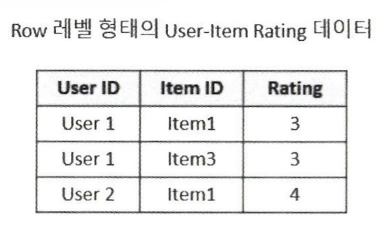

In [ ]:
# SVD로 잠재 요인 협업 필터링 수행
algo = SVD()  # 알고리즘 객체 생성
algo.fit(trainset)  # 학습 데이터 세트 기반으로 추천 알고리즘 학습

* Surprise에서 추천을 예측하는 메서드는 test()와 predict() 두 개
  * test()는 사용자-아이템 평점 데이터 세트 전체에 대해서 추천을 예측하는 메서드. 즉, 입력된 데이터 세트에 대해 추천 데이터 세트를 만들어 줌
  * predict()는 개별 사용자와 영화에 대한 추천 평점을 반환해 줌

In [ ]:
# test() 메서드 실행
# 테스트 데이터 세트 전체에 대해 추천 영화 평점 데이터를 생성한 뒤에 최초 5개만 추출
predictions = algo.test(testset)
print('prediction type:', type(predictions), 'size:', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type: <class 'list'> size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.580445892412626, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.8062636289718164, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=3.749282542863726, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.71337997389996, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.251389224011936, details={'was_impossible': False})]

→ SVD 알고리즘 객체의 test(데이터 세트) 메서드의 호출 결과는 파이썬 리스트이며 크기는 입력 인자 데이터 세트의 크기와 같은 25000개

→ 호출 결과로 반환된 리스트 객체는 25000개의 Prediction 객체를 내부에 가지고 있음

→ Prediction 객체는 Surprise 패키지에서 제공하는 데이터 타입. 개별 사용자 아이디(uid), 영화(또는 아이템) 아이디(iid)와 실제 평점(r_ui) 정보에 기반해 Surprise의 추천 예측 평점(est) 데이터를 튜플 형태로 가지고 있음

→ Prediction 객체의 details 속성은 내부 처리 시 추천 예측을 할 수 없는 경우에 로그용으로 데이터를 남기는 데 사용됨. 'was_impossible'이 True이면 예측값을 생성할 수 없는 데이터라는 의미

→ 리스트 객체 내에 내포된 Prediction 객체의 uid, iid, r_ui, est 등의 속성에 접근하려면 객체명.uid와 같은 형식으로 가능

In [ ]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.580445892412626),
 ('882', '291', 3.8062636289718164),
 ('535', '507', 3.749282542863726)]

In [ ]:
# predict() 메서드 실행
# predict()는 개별 사용자의 아이템에 대한 추천 평점을 예측

# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.10   {'was_impossible': False}


→ 결과처럼 predict()는 개별 사용자와 아이템 정보를 입력하면 추천 예측 평점을 est로 반환

→ test() 메서드는 입력 데이터 세트의 모든 사용자와 아이템 아이디에 대해서 predict()를 반복적으로 수행한 결과라고 생각하면 이해하기 쉬움

In [ ]:
# 테스트 데이터 세트 이용해 추천 예측 평점과 실제 평점과의 차이 평가
accuracy.rmse(predictions)

RMSE: 0.9481


0.9481425387222899

**Surprise 주요 모듈 소개**

**Dataset**

* Surprise는 user_id(사용자 아이디), item_id(아이템 아이디), rating(평점) 데이터가 로우 레벨로 된 데이터 세트만 적용할 수 있음
* 데이터의 첫 번째 칼럼을 사용자 아이디, 두 번째 칼럼을 아이템 아이디, 세 번째 칼럼을 평점으로 가정해 데이터를 로딩하고 네 번째 칼럼부터는 아예 로딩을 수행하지 않음

|API 명|내용|
|:---|:---|
|Dataset.load_builtin|무비렌즈 아카이브 FTP 서버에서 무비렌즈 데이터를 내려받음. ml-100k, ml-1M를 내려받을 수 있음.|
(name='ml-100k')|일단 내려받은 데이터는 surprise_data 디렉터리 밑에 저장되고, 해당 디렉터리에 데이터가 있으면 FTP에서 내려받지 않고 해당 데이터를 이용함.|
||입력 파라미터인 name으로 대상 데이터가 ml-100k인지 ml-1M인지를 입력함. 디폴트는 ml-100k|
|Dataset.load_from_file|OS 파일에서 데이터를 로딩할 때 사용함.|
|(file_path, reader)|콤마, 탭 등으로 칼럼이 분리된 포맷의 OS 파일에서 데이터를 로딩함.|
||입력 파라미터로 OS 파일명, Reader로 파일의 포맷을 지정함.|
|Dataset.load_from_df|판다스의 DataFrame에서 데이터를 로딩. 파라미터로 DataFrame을 입력받으며 DataFrame 역시|
|(df, reader)|반드시 3개의 칼럼인 사용자 아이디, 아이템 아이디, 평점 순으로 칼럼 순서가 정해져 있어야 함.|
||입력 파라미터로 DataFrame 객체, Reader로 파일의 포맷을 지정함.|


**OS 파일 데이터를 Surprise 데이터 세트로 로딩**

* Surprise에 OS 파일을 로딩할 때의 주의할 점 - 로딩되는 데이터 파일에 칼럼명을 가지는 헤더 문자열이 있어서는 안 됨

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget -c https://github.com/euphoris/datasets/raw/master/ml-100k.zip

--2023-08-10 06:02:14--  https://github.com/euphoris/datasets/raw/master/ml-100k.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/euphoris/datasets/master/ml-100k.zip [following]
--2023-08-10 06:02:15--  https://raw.githubusercontent.com/euphoris/datasets/master/ml-100k.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 873734 (853K) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>] 853.26K  --.-KB/s    in 0.03s   

2023-08-10 06:02:15 (28.5 MB/s) - ‘ml-100k.zip’ saved [873734/873734]



In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
import pandas as pd

# ratings_noh.csv 파일로 언로드 시 인덱스와 헤더를 모두 제거한 새로운 파일 생성
ratings.to_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings_noh.csv', index=False, header=False)

In [ ]:
# Reader 클래스 이용해 데이터 파일의 파싱 포맷 정의
from surprise import Reader

# Reader 클래스의 생성자에 각 필드의 칼럼명과 칼럼 분리문자, 최소~최대 평점 입력해 객체 생성
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# load_from_file()로 생성된 Reader 객체를 참조해 데이터 파일을 파싱하면서 로딩
data = Dataset.load_from_file('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings_noh.csv', reader=reader)

* Surprise 데이터 세트는 기본적으로 무비렌즈 데이터 형식을 따르므로 무비렌즈 데이터 형식이 아닌 다른 OS 파일의 경우 Reader 클래스를 먼저 설정해야 함
* Reader 클래스의 주요 생성 파라미터
  * line_format(string): 칼럼을 순서대로 나열함. 입력된 문자열을 공백으로 분리해 칼럼으로 인식
  * sep(char): 칼럼을 분리하는 분리자이며, 디폴트는 '\t'. 판다스 DataFrame에서 입력받을 경우에는 기재할 필요 없음
  * rating_scale(tuple, optional): 평점 값의 최소~최대 평점을 설정함. 디폴트는 (1, 5)이지만 ratings.csv 파일의 경우 최소 평점이 0.5, 최대 평점이 5이므로 (0.5, 5)로 설정

In [ ]:
# SVD 행렬 분해 기법 이용해 추천 예측
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행 시마다 동일한 결과를 도출하기 위해 random_state 설정
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 나서 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

**판다스 DataFrame에서 Surprise 데이터 세트로 로딩**

* DataFrame 역시 사용자 아이디, 아이템 아이디, 평점 칼럼 순서를 지켜야 함

In [ ]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('ml-100k.zip')
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 함
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9458


0.9457855197571977

**Surprise 추천 알고리즘 클래스**

* Surprise에서 추천 예측을 위해 자주 사용되는 추천 알고리즘 클래스

|클래스명|설명|
|:---|:---|
|SVD|행렬 분해를 통한 잠재 요인 협업 필터링을 위한 SVD 알고리즘|
|KNNBasic|최근접 이웃 협업 필터링을 위한 KNN 알고리즘|
|BaselineOnly|사용자 Bias와 아이템 Bias를 감안한 SGD 베이스라인 알고리즘|

* Surprise SVD의 비용 함수는 사용자 베이스라인(Baseline) 편향성을 감안한 평점 예측에 Regularization을 적용한 것
* SVD 클래스의 입력 파라미터


|파라미터명|내용|
|:---|:---|
|n_factors|잠재 요인 K의 개수. 디폴트는 100. 커질수록 정확도가 높아질 수 있으나 과적합 문제 발생할 수 있음|
|n_epochs|SGD(Stochastic Gradient Descent) 수행 시 반복 횟수. 디폴트는 20|
|biased(bool)|베이스라인 사용자 편향 적용 여부. 디폴트는 True|

**베이스라인 평점**

* 베이스라인 평점(Baseline Rating): 개인의 성향을 반영해 아이템 평가에 편향성(bias) 요소를 반영하여 평점을 부과하는 것
* 보통 베이스라인 평점은 전체 평균 평점 + 사용자 편향 점수 + 아이템 편향 점수 공식으로 계산
  * 전체 평균 평점 = 모든 사용자의 아이템에 대한 평점을 평균한 값
  * 사용자 편향 점수 = 사용자별 아이템 평점 평균 값 - 전체 평균 평점
  * 아이템 편향 점수 = 아이템별 평점 평균 값 - 전체 평균 평점

**교차 검증과 하이퍼 파라미터 튜닝**

* Surprise는 교차 검증과 하이퍼 파라미터 튜닝을 위해 사이킷런과 유사한 cross_validate()와 GridSearchCV 클래스 제공
  * cross_validat() 함수는 surprise.model_selection 모듈 내에 존재하며, 폴드된 데이터 세트의 개수와 성능 측정 방법을 명시해 교차 검증을 수행함

In [ ]:
# crsoss_validate() 이용해 데이터를 5개의 학습/검증 폴드 데이터 세트로 분리해 교차 검증 수행하고 RMSE, MAE로 성능 평가
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8754  0.8751  0.8729  0.8693  0.8707  0.8727  0.0024  
MAE (testset)     0.6732  0.6712  0.6703  0.6692  0.6700  0.6708  0.0014  
Fit time          1.47    1.52    2.20    1.68    1.46    1.66    0.28    
Test time         0.14    0.22    0.22    0.36    0.15    0.22    0.08    


{'test_rmse': array([0.8754105 , 0.87505534, 0.87294039, 0.86933415, 0.87072181]),
 'test_mae': array([0.67315609, 0.67124117, 0.67032829, 0.66919898, 0.66998981]),
 'fit_time': (1.468623399734497,
  1.5188853740692139,
  2.198782444000244,
  1.6766040325164795,
  1.4601209163665771),
 'test_time': (0.13773107528686523,
  0.2249147891998291,
  0.22086191177368164,
  0.3591885566711426,
  0.15034055709838867)}

→ cross_validate()는 위의 출력 결과와 같이 폴드별 성능 평가 수치와 전체 폴드의 평균 성능 평가 수치를 함께 보여줌

* Surprise의 GridSearchCV도 사이킷런의 GridSearchCV와 유사하게 교차 검증을 통한 하이퍼 파라미터 최적화를 수행함
* 하이퍼 파라미터 최적화는 알고리즘 유형에 따라 다를 수 있지만, SVD의 경우 주로 점진적 하강 방식(Stomachastic Gradient Descent)의 반복 횟수를 지정하는 n_epochs와 SVD의 잠재 요인 K의 크기를 지정하는 n_factors를 튜닝함

In [ ]:
# 'n_epochs':[20, 40, 60], 'n_factors':[50, 100, 200]로 변경하면서 CV가 3일 때의 최적 하이퍼 파라미터 도출
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mae로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8771228421737886
{'n_epochs': 20, 'n_factors': 50}


→ 'n_epochs': 20, 'n_factors': 50일 때 3개 폴드의 검증 데이터 세트에서 최적 RMSE가 0.877로 도출

**Surprise를 이용한 개인화 영화 추천 시스템 구축**

Surprise 패키지로 학습된 추천 알고리즘을 기반으로 특정 사용자가 아직 평점을 매기지 않은 영화 중에서 개인 취향에 가장 적절한 영화 추천



In [ ]:
# 다음 코드는 train_test_split()으로 분리되지 않는 데이터 세트에 fit()을 호출해 오류 발생

# data=Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# algo=SVD(n_factors=50, random_state=0)
# algo.fit(data)

* 데이터 세트 전체를 학습 데이터로 사용하려면 DatasetAutoFolds 클래스를 이용
  * DatasetAutoFolds 객체 생성한 뒤 build_full_trainset() 메서드 호출하면 전체 데이터를 학습 데이터 세트로 만들 수 있음

In [ ]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성
data_folds = DatasetAutoFolds(ratings_file='/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성함
trainset = data_folds.build_full_trainset()

In [ ]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [ ]:
# userId 9가 아직 평점을 매기지 않은 영화를 movieId 42로 선정한 뒤 예측 평점 계산

# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies = pd.read_csv('/content/drive/MyDrive/ESAA/OB/data/ml-latest-small/movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds=ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds==42].count()==0:
  print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [ ]:
# predict() 메서드 이용해 movieId 42인 영화에 대해서 userId 9 사용자의 추천 예상 평점 구하기
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


→ 추천 예측 평점은 est 값으로 3.13

→ 사용자가 평점을 매기지 않은 영화의 추천 예측 평점을 간단하게 구하는 방법을 알았으니 이제 사용자가 평점을 매기지 않은 전체 영화를 추출한 뒤에 예측 평점 순으로 영화 추천

In [ ]:
# 사용자가 아직 평점을 매기지 않은 영화 정보 반환

def get_unseen_surprise(ratings, movies, userId):
  # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies = ratings[ratings['userId']==userId]['movieId'].tolist()

  # 모든 영화의 movieId를 리스트로 생성
  total_movies = movies['movieId'].tolist()

  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

  return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


→ 사용자 아이디 9번은 전체 9742개의 영화 중에서 46개만 평점을 매김

→ 따라서 추천 대상 영화는 9696개

→ 이중 앞에서 학습된 추천 알고리즘 클래스인 SVD를 이용해 높은 예측 평점을 가진 순으로 영화 추천

In [ ]:
# 함수 생성 - 인자로 학습이 완료된 추천 알고리즘 객체, 추천 대상 사용자 아이디, 추천 대상 영화의 리스트 객체, 추천 상위 N개 개수를 받음
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
  # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list로 저장
  predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  # predictions list 객체는 surprise의 predictions 객체를 원소로 갖고 있다.
  # [Prediction(uid='9', iid='1', est=3.69), Predictions(uid='9', iid='2', est=2.98),,,]

  # 이를 est 값으로 정렬하기 위해 아리애 sortkey_est 함수 정의
  # sortdey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행
  def sortkey_est(pred):
    return pred.est

  # sortkey_est() 반환값의 내림차순으로 정렬 수행하고 top_n개의 최상위 값 추출
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions = predictions[:top_n]

  # top_n 으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids = [int(pred.iid) for pred in top_predictions]
  top_movie_rating = [pred.est for pred in top_predictions]
  top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
  top_movie_preds = [(id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('### top-10 추천 영화 리스트 ###')
for top_movie in top_movie_preds:
  print(top_movie[1], ':', top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
### top-10 추천 영화 리스트 ###
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


###**09 정리**

* 추천 시스템의 대표적인 방식
  * 콘텐츠 기반 필터링: 아이템(상품, 영화, 서비스 등)을 구성하는 여러가지 콘텐츠 중 사용자가 좋아하는 콘텐츠를 필터링하여 이에 맞는 아이템을 추천하는 방식
  * 협업 필터링
    * 최근접 이웃 협업 필터링: 사용자 기반(사용자-사용자)과 아이템 기반(아이템-아이템)으로 나뉘며, 이중 아이템 기반이 더 많이 사용됨. 아이템 기반 최근접 이웃 방식은 특정 아이템과 가장 근접하게 유사한 다른 아이템들을 추천하는 방식
    * 잠재 요인 협업 필터링: 사용자-아이템 평점 행렬 데이터에 숨어 있는 잠재 요인을 추출하여 사용자가 아직 평점을 매기지 않은 아이템에 대한 평점을 예측하여 이를 추천에 반영하는 방식
  * 파이썬의 추천 시스템 패키지 Surprise